<a href="https://colab.research.google.com/github/prabindebnath25/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time


from geopy import distance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge,ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# We will use haverseine to calculate the distance using the longitudinal and lattitue data.
!pip install haversine
from haversine import haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing the dataset

In [2]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [110]:
# load the data
path = "/content/drive/MyDrive/regression capstone project/NYC Taxi Data.csv"
df = pd.read_csv(path)

In [58]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# EDA


In [59]:
# Check shape of the data
shape = df.shape
print(f"Number of rows {shape[0]} \nNumber of columns {shape[1]}")

Number of rows 1458644 
Number of columns 11


In [60]:
# Reveal information about the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [61]:
# Check if it contains null values.
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There is no null values in the data

In [62]:
duplicate_row = df.duplicated().sum()
print(f"number of duplicate row = {duplicate_row}")

number of duplicate row = 0


In [63]:
# Get some statiscis.
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [64]:
# Change format for pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [65]:
# Retrive day, month and hour data and drop 'pickup_datetime', 'dropoff_datetime' columns
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month'] = df['pickup_datetime'].dt.month

# Retrive pickup and dropoff hrs.
df['pickup_hour'] = df.pickup_datetime.dt.hour
df['dropoff_hour'] = df.dropoff_datetime.dt.hour

df.drop(columns=['pickup_datetime', 'dropoff_datetime'], inplace= True)

In [66]:
# After the above transformation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   passenger_count     1458644 non-null  int64  
 3   pickup_longitude    1458644 non-null  float64
 4   pickup_latitude     1458644 non-null  float64
 5   dropoff_longitude   1458644 non-null  float64
 6   dropoff_latitude    1458644 non-null  float64
 7   store_and_fwd_flag  1458644 non-null  object 
 8   trip_duration       1458644 non-null  int64  
 9   weekday             1458644 non-null  int64  
 10  month               1458644 non-null  int64  
 11  pickup_hour         1458644 non-null  int64  
 12  dropoff_hour        1458644 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 144.7+ MB


## Trip duration

In [67]:
df['trip_duration'].sort_values()

207497           1
1382872          1
1360664          1
346102           1
1034341          1
            ...   
1234291      86392
355003     1939736
680594     2049578
924150     2227612
978383     3526282
Name: trip_duration, Length: 1458644, dtype: int64

In [68]:
# Get rid of the extreme values.
# df = df[df['trip_duration'] < 100000]

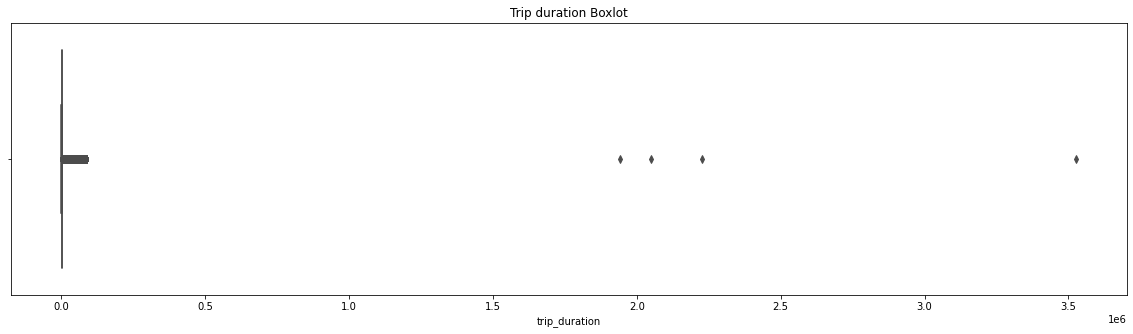

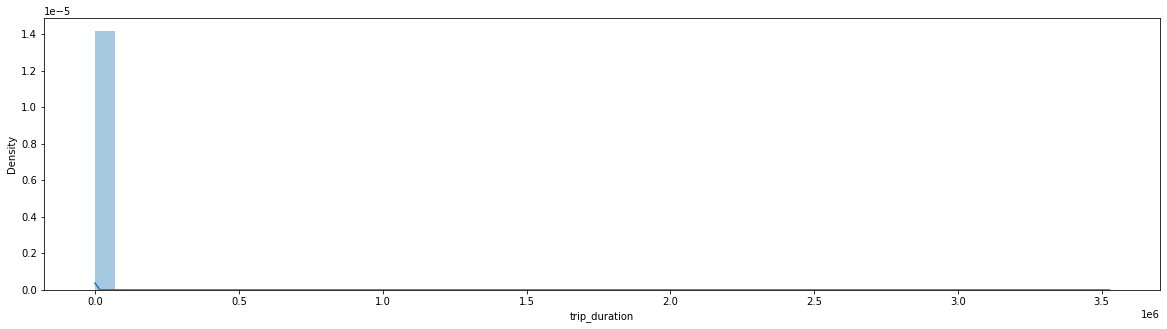

In [69]:
# Check out the trip_duration.
plt.figure(figsize=(20,5))
sns.boxplot(df['trip_duration'], color='orange')
plt.title('Trip duration Boxlot')
plt.show()
plt.figure(figsize=(20,5))
sns.distplot(df['trip_duration'])

In [70]:
# Create a function that returns upper and lower bounds for removing outliers.
def outlier_treatment(feature):
  sorted(feature)
  Q1,Q3 = np.percentile(feature , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [71]:
# Get upper/lower bounds for distance.
lowerbound,upperbound = outlier_treatment(df['trip_duration'])
print(f"lowerbound {lowerbound},     upperbound {upperbound}")


lowerbound -620.0,     upperbound 2092.0


In [72]:
# drop the rows with outliers with more then 10 hrs and also remove the trips with zero second time
df = df[(df['trip_duration'] < upperbound) & (df['trip_duration'] > 0) ]

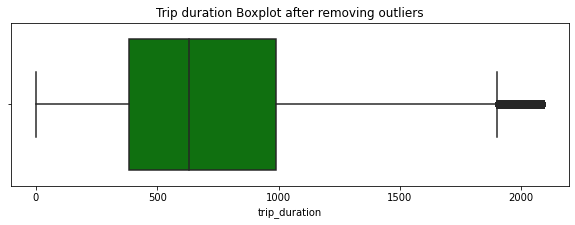

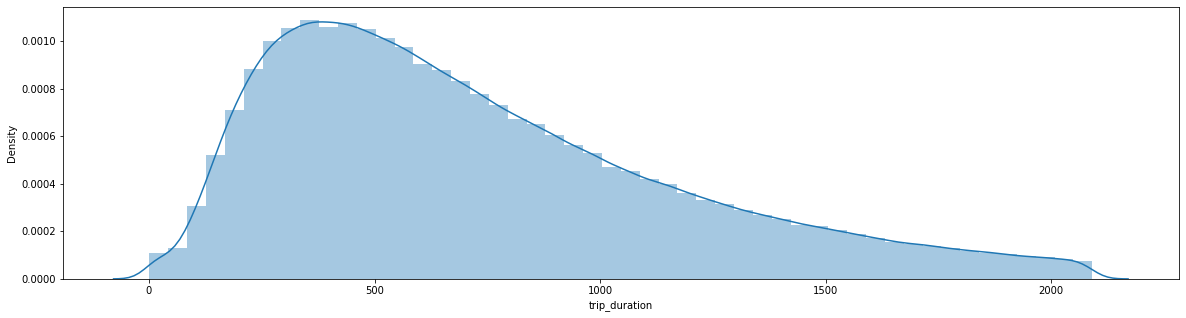

In [73]:
# Check out the trip_duration after removing outlieers
plt.figure(figsize=(10,3))
sns.boxplot(df['trip_duration'], color='green')
plt.title('Trip duration Boxplot after removing outliers')
plt.show()
plt.figure(figsize=(20,5))
sns.distplot(df['trip_duration'])
plt.show()

## Vendor ID

In [74]:
# Value counts for vendot id
df.vendor_id.value_counts()

2    738561
1    645759
Name: vendor_id, dtype: int64

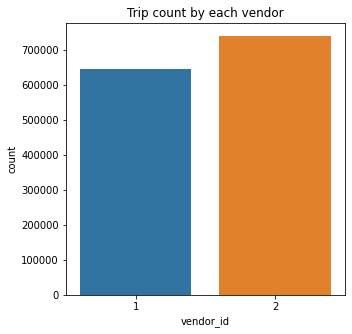

In [75]:
# plot number of trios by each vendors
plt.figure(figsize= (5,5))
sns.countplot(df['vendor_id'])
plt.title("Trip count by each vendor")
plt.show()

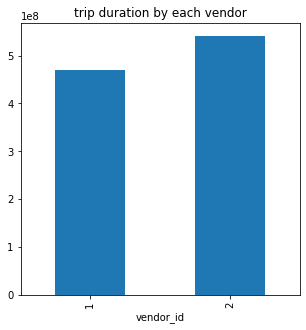

In [76]:
# Trip time comparison for each vendor
plt.figure(figsize= (5,5))
df.groupby(['vendor_id'])['trip_duration'].sum().plot(kind = 'bar')
plt.title('trip duration by each vendor')
plt.show()

* trip count of bendor 2 is more then vendor 1
* also total trip duration in vendor 2 is more thn vendor 1

## Passenger counts


In [77]:
# Value counts on passenger_count
df['passenger_count'].value_counts()

1    983813
2    197618
5     73857
3     56556
6     45799
4     26616
0        56
7         3
9         1
8         1
Name: passenger_count, dtype: int64

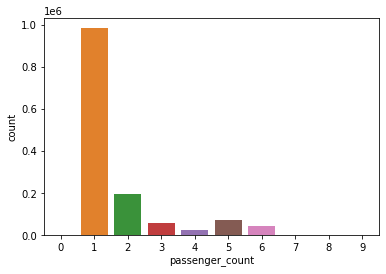

In [78]:
# Count plot on passenger_counts
sns.countplot(df['passenger_count'])
plt.show()

* ***some values are zero which mean either the trip was cancled or there was an error in the data entry.***
* ***7, 8, 9 are extreme cases considering the capacity of a car, so we will get rid of them.***
* ***most of the trips contain atmost 1 or 2 passengers.***

In [79]:
# removing rows with unwanted passenger counts
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <=6)]

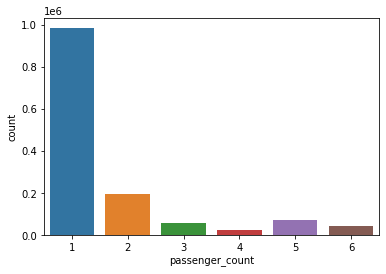

In [80]:
# after removing un wanted passenger counts
sns.countplot(df['passenger_count'])
plt.show()

## Pickup and drop off longitude and latitude

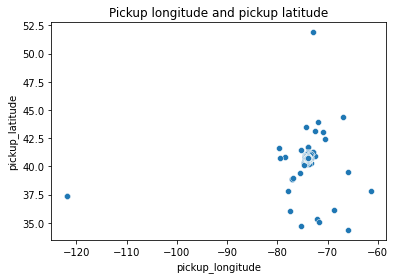

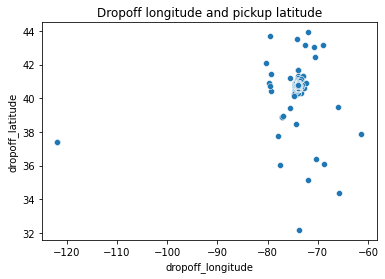

In [81]:
# We cereate scatterplot fot the longitude and latitude for pickup and drop off
sns.scatterplot(df['pickup_longitude'], df['pickup_latitude'])
plt.title("Pickup longitude and pickup latitude")
plt.show()
print("\n")
sns.scatterplot(df['dropoff_longitude'], df['dropoff_latitude'])
plt.title("Dropoff longitude and pickup latitude")
plt.show()

* There are some extreme values in the data
* we get rid of them

In [82]:
# removing extreme values
df = df[(df['pickup_longitude']> -110) & (df['pickup_latitude'] < 50)]
df = df[(df['dropoff_longitude']> -110) & (df['dropoff_latitude'] >34)]

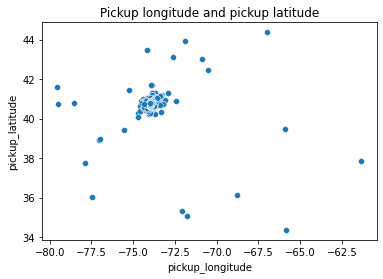

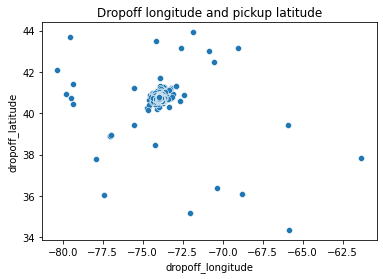

In [83]:
# this is how the data looks like after removing extreme values
sns.scatterplot(df['pickup_longitude'], df['pickup_latitude'])
plt.title("Pickup longitude and pickup latitude")
plt.show()
print("\n")
sns.scatterplot(df['dropoff_longitude'], df['dropoff_latitude'])
plt.title("Dropoff longitude and pickup latitude")
plt.show()

In [84]:
# Function to calculate distance using the haversine function as we are provided with gps data.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [85]:
# Calculate distance 
df['distance'] = df.apply(lambda x: calc_distance(x), axis = 1)


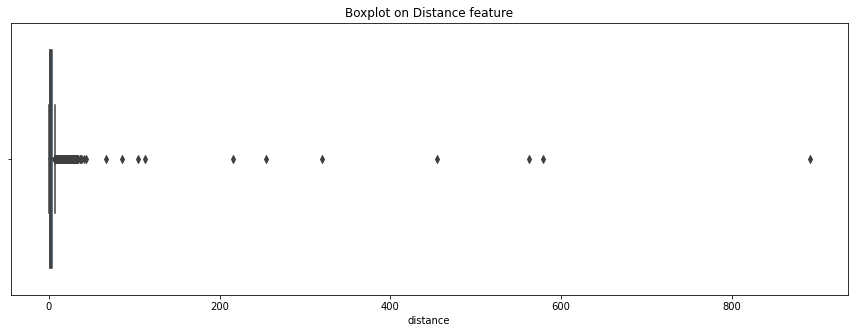

In [86]:
# Boxplot on Distance feature
plt.figure(figsize= (15,5))
sns.boxplot(df['distance'])
plt.title('Boxplot on Distance feature')
plt.show()

There are outliers in the data. To remove outliers, we will be using the IQR method.

In [87]:
# Create a function that returns upper and lower bounds for removing outliers.
def outlier_treatment(feature):
  sorted(feature)
  Q1,Q3 = np.percentile(feature , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [88]:
# Get upper/lower bounds for distance.
lowerbound,upperbound = outlier_treatment(df['distance'])
print(f"lowerbound {lowerbound},     upperbound {upperbound}")


lowerbound -2.2328428324508605,     upperbound 6.916788366936758


To clean the data we use upper bound from the IQR method and for lower bound we use 0.1. 


In [89]:
# Get rid of zero distance  and distances less then 100 km
df = df[(df['distance'] > 0) & (df['distance'] < upperbound )]

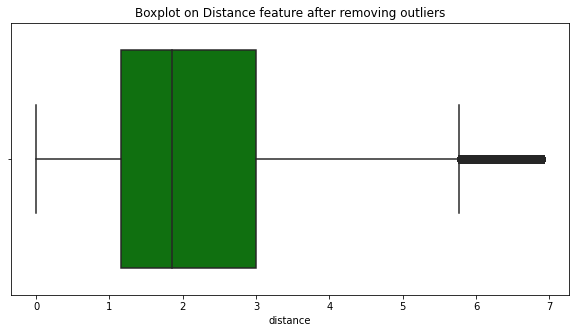

In [90]:
# After removing the outliers
plt.figure(figsize= (10,5))
sns.boxplot(df['distance'], color= 'green')
plt.title('Boxplot on Distance feature after removing outliers')
plt.show()

## store_and_fwd_flag.

In [91]:
df['store_and_fwd_flag'].value_counts()

N    1264779
Y       6055
Name: store_and_fwd_flag, dtype: int64

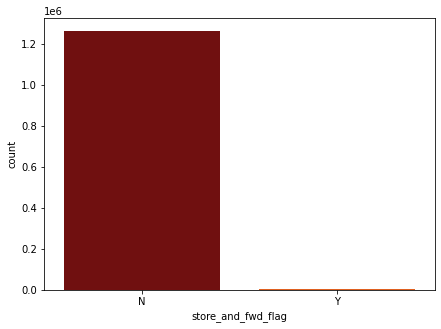

In [92]:
# Plot it.
fig = plt.figure(figsize=(7,5))
plot = sns.countplot(df['store_and_fwd_flag'], palette='gist_heat')
plt.show()

* most of the data values are N and only few values are Y, which means most of the data was uploaded directly without storing it and forwarding.
* this ia a categorical feature which we will be converting into numeric by getting dummies.

## Pickup_datetime / Dropoff_datetime

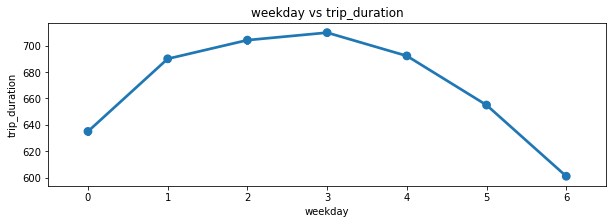

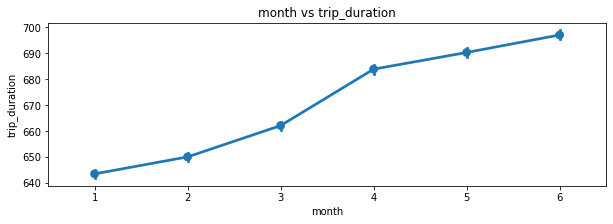

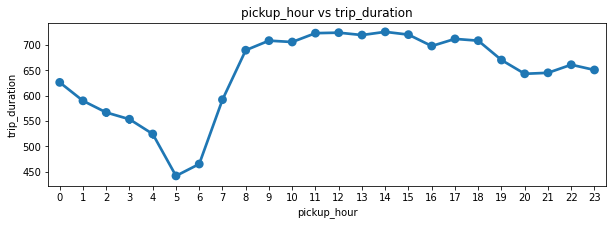

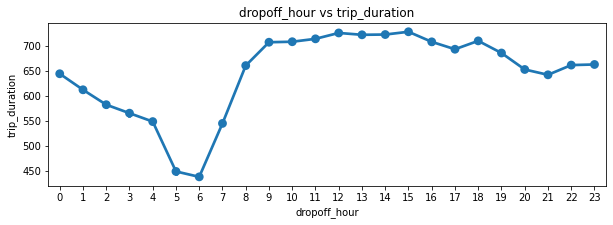

In [93]:
# pointplot on hour, month and weekdays
features = ['weekday', 'month','pickup_hour', 'dropoff_hour']
for feature in features:
    fig = plt.figure(figsize=(10,3))
    sns.pointplot(x= df[feature], y= df['trip_duration'])
    plt.title(f'{feature} vs trip_duration')
    plt.show()
    print("\n \n")

* ***Commute is least in early morning and late night.***
* ***trip duration decreases as the weekend approches, it makes sense as most of the people either stay at home or go for vacations.***
* ***trip duration increases after Feburary***.


# Feature engineering and Data Preparition


In [94]:
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'weekday', 'month',
       'pickup_hour', 'dropoff_hour', 'distance'],
      dtype='object')

In [95]:
# Since there are total 24 different values in these two columns it would be better to categorize them and get dummies for them.

# Function to convert pickup/dropoff hours to category.

def hour_category(hour):
    if hour>=7 and hour<=10:
        return 'morning(7-9)'
    elif hour>10 and hour<16:
        return 'afternoon(9-16)'
    elif hour>=16 and hour<=19:
        return 'evening(16-19)'
    elif hour>19 and hour <= 23:
        return 'night(20-23)'
    else:
        return 'latenight(23 onwards)'


In [96]:
#  apply hour category to hour column
df['pickup_time'] = df['pickup_hour'].apply(lambda x: hour_category(x))
df['dropoff_time'] = df['dropoff_hour'].apply(lambda x: hour_category(x))
# drop hour colun
df.drop(columns= ['pickup_hour', 'dropoff_hour'], inplace= True)

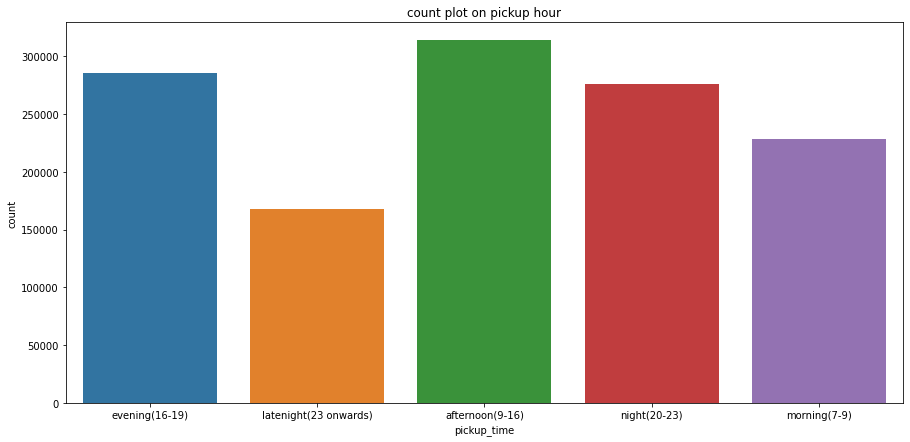

In [98]:
plt.figure(figsize=(15,7))
sns.countplot(df['pickup_time'])
plt.title("count plot on pickup hour")
plt.show()

In [99]:
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'weekday', 'month', 'distance',
       'pickup_time', 'dropoff_time'],
      dtype='object')

In [111]:
# drop some colums
df.drop(columns = ['id'], inplace = True)

In [102]:
df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'weekday', 'month', 'distance', 'pickup_time',
       'dropoff_time'],
      dtype='object')

In [103]:
# One hot encoding
df = pd.get_dummies(df, columns= ['vendor_id', 'passenger_count','store_and_fwd_flag', 'weekday', 'month', 'pickup_time', 'dropoff_time'], drop_first= True)

In [104]:
df.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'distance', 'vendor_id_2',
       'passenger_count_2', 'passenger_count_3', 'passenger_count_4',
       'passenger_count_5', 'passenger_count_6', 'store_and_fwd_flag_Y',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'pickup_time_evening(16-19)', 'pickup_time_latenight(23 onwards)',
       'pickup_time_morning(7-9)', 'pickup_time_night(20-23)',
       'dropoff_time_evening(16-19)', 'dropoff_time_latenight(23 onwards)',
       'dropoff_time_morning(7-9)', 'dropoff_time_night(20-23)'],
      dtype='object')

In [105]:
df.head().T

,0,1,3,4,5
pickup_longitude,-73.982155,-73.980415,-74.010040,-73.973053,-73.982857
pickup_latitude,40.767937,40.738564,40.719971,40.793209,40.742195
dropoff_longitude,-73.964630,-73.999481,-74.012268,-73.972923,-73.992081
dropoff_latitude,40.765602,40.731152,40.706718,40.782520,40.749184
trip_duration,455.000000,663.000000,429.000000,435.000000,443.000000
distance,1.498523,1.805510,1.485500,1.188590,1.098944
vendor_id_2,1.000000,0.000000,1.000000,1.000000,1.000000
passenger_count_2,0.000000,0.000000,0.000000,0.000000,0.000000
passenger_count_3,0.000000,0.000000,0.000000,0.000000,0.000000
passenger_count_4,0.000000,0.000000,0.000000,0.000000,0.000000


In [106]:
df.shape

(1270834, 32)

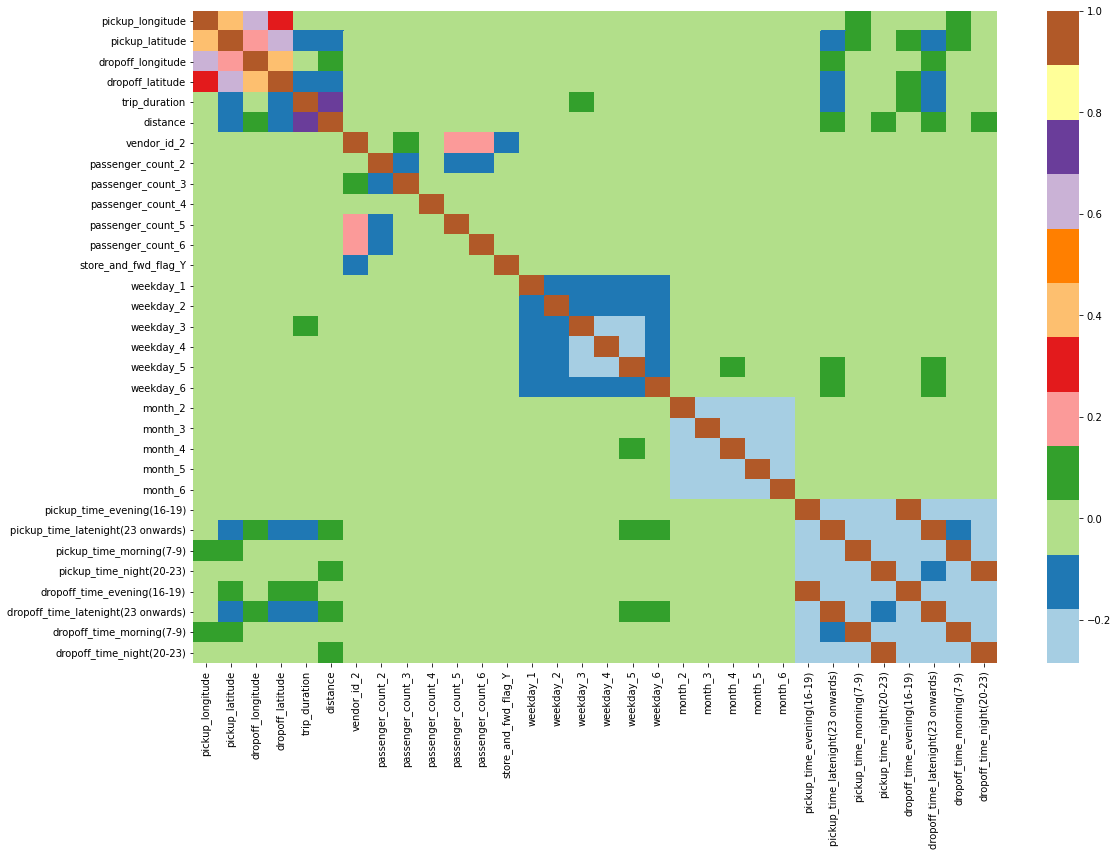

In [109]:
fig = plt.figure(figsize=(18,12))
sns.heatmap(df.corr(), cmap='Paired')
plt.show()

In [108]:
dependent_variables = ['trip_duration']
independent_variables = [i for i in df.columns if i not in dependent_variables]

In [ ]:
# get x and y values
X = df[independent_variables]
y = df[dependent_variables]
# Train Test Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state =5)

In [ ]:
# Scale the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Selection

**Models we will be building:**
* **Linear Regression**
* **Decision Tree Regressorr**
* **XG Boost Regressor**
* **Hist Gradient Boosting Regressor**
* **AdaBoostRegressor**


In [ ]:
# Defining the models to be used.
models = [
            ['Linear Regression', LinearRegression()],
          ['Decision Tree Regressor', DecisionTreeRegressor()],
          ['XG Boost Regressor', xgb.XGBRegressor()],
          ['Hist Gradient Boosting Regressor', HistGradientBoostingRegressor()],
          ['AdaBoostRegressor', AdaBoostRegressor()],
          ]

In [ ]:
# creating a loop to train all the models and get eveluation metrics
model_eveluation_metrices =[]
for name, model in models:
    working_model ={}
    working_model['name'] = name
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    working_model['train_time'] = end - start
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    working_model["Train_R2_Score"] = r2_score(y_train, y_pred_train)
    working_model["Test_R2_Score"] = r2_score(y_test, y_pred_test)
    working_model["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test, y_pred_test))
    model_eveluation_metrices.append(working_model)





In [ ]:
# Table of eveluation metrices of each Algorithms
model_eveluation_metrices_df = pd.DataFrame(model_eveluation_metrices)
model_eveluation_metrices_df


,name,train_time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Linear Regression,0.975460,0.542098,0.540535,269.141373
1,Decision Tree Regressor,17.781095,1.000000,0.394014,309.090249
2,XG Boost Regressor,65.460500,0.706406,0.696809,218.631388
3,Hist Gradient Boosting Regressor,15.928167,0.670807,0.667865,228.829203
4,AdaBoostRegressor,82.710132,0.380508,0.377837,313.188765


Looking at the above Performance Matrix we can say thay XGBoost and Hist Gradient Boosting Regressor are the best model for this dataset. however Hist Gradient Boosting Regressor model takes significantly less time so we decided to tune Hist Gradient Boosting Regressor model.

# Hyperparameter Tuning:

We will tune the parameters of Hist Gradient Boosting Regressor for better results.

In [ ]:
# creating parameters
max_depth = [8,10]
learning_rate = [0.4,.6]
min_samples_leaf = [50,60]
max_iter = [400,500]

# param_dict
param_dict = {
    'learning_rate' : learning_rate, 
    'max_depth' : max_depth, 
    'min_samples_leaf' : min_samples_leaf ,
    'max_iter' : max_iter
}

In [ ]:
# define the model 
hgbt = HistGradientBoostingRegressor()
#Grid Serch
hgbt_grid = RandomizedSearchCV(estimator= hgbt, param_distributions= param_dict, cv = 5, verbose = 2, scoring= 'r2')

# Train model
start = time.time()
hgbt_grid.fit(X_train, y_train)
end = time.time()
print("\n=========================================================\n")
print("Time required top train  ",end - start)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.6, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  25.8s
[CV] END learning_rate=0.6, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  34.7s
[CV] END learning_rate=0.6, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  36.7s
[CV] END learning_rate=0.6, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  34.3s
[CV] END learning_rate=0.6, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  38.8s
[CV] END learning_rate=0.4, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  38.4s
[CV] END learning_rate=0.4, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  37.3s
[CV] END learning_rate=0.4, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  37.2s
[CV] END learning_rate=0.4, max_depth=8, max_iter=400, min_samples_leaf=60; total time=  37.7s
[CV] END learning_rate=0.4, max_depth=8, max_iter=400, min_samples_leaf=60; total ti

In [ ]:

# Get the parameters
print("\n=========================================================\n")
print("Best parameters are  \n",hgbt_grid.best_params_)

# predit 
y_train_preds = hgbt_grid.best_estimator_.predict(X_train)
y_test_preds = hgbt_grid.best_estimator_.predict(X_test)

print("\n=========================================================\n")
Train_R2_Score = r2_score(y_train,y_train_preds)
Train_RMSE_Score = np.sqrt(mean_squared_error(y_train,y_train_preds))

Test_R2_Score = r2_score(y_test, y_test_preds)
Test_RMSE_Score = np.sqrt(mean_squared_error(y_test, y_test_preds))
print(f"Train_R2_Score  {Train_R2_Score}")
print(f"Test_R2_Score  {Test_R2_Score}")
print(f"Train_RMSE_Score   {Train_RMSE_Score}")
print(f"Test_RMSE_Score   {Test_RMSE_Score}")
print("\n=========================================================\n")



Best parameters are  
 {'min_samples_leaf': 50, 'max_iter': 500, 'max_depth': 8, 'learning_rate': 0.4}


Train_R2_Score  0.7372568000095774
Test_R2_Score  0.717591763647963
Train_RMSE_Score   203.88610219621287
Test_RMSE_Score   211.00499291078603




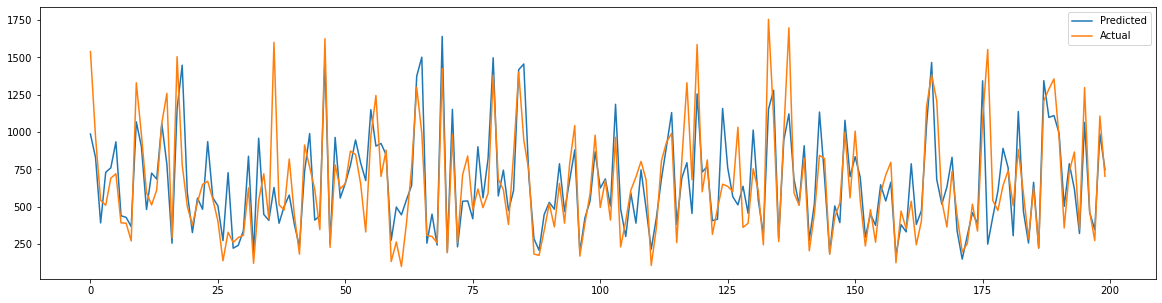

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(np.array(y_test_preds)[:200])
plt.plot(np.array(y_test)[:200])
plt.legend(["Predicted","Actual"])
plt.show()

# Conclusion
In this project ,covered various aspects of the Machine learning development cycle amd observed that the data exploration and variable analysis is a very important for the cycle and should be done for thorough understanding of the data. Also cleaned the data while exploring as there were some outliers which should be treated before feature engineering. Further performed feature engineering to filter and gather only the optimal features which are more significant.